# Social Network Analysis - Exercise Sheet 5


### Bipartite Graph Generators

The random generation of graphs is important for the task of network analysis.
There is a multitude of random generators for graphs available, the most prominent being the Erdős–Rényi model.
In the field of social network analysis the Watts and Strogatz model (small-worlds) and the Barabási–Albert model (scale-free networks with preferential attachment) also became prominent generation models to more adequately generate networks mimicking at least some aspects of empirically observed networks.

However, none of these models can be used as is to generate bipartite graphs and bipartite graphs were analyzed by projecting them to both partitions and analyzing the projected graphs using standard graph measures. 
This way of analyzing bipartite networks drew criticism for not resulting in 

Therefore, it was nessessary to come up with more appropriate generation models for this important class of networks.

In [374]:
# Execute this cell to show the PDF containing the paper or open the PDF seperately
from IPython.display import IFrame
#IFrame("./texts/Bipartite_graphs_as_models_of_complex_networks.pdf", width='100%', height=800)

### Preferential Attachment

Preferential attachment means that the more connected a node is, the more likely it is to receive new links. Nodes with higher degree have stronger ability to grab links added to the network.

Formally:
The probability that a new node is connected to the node $i$ is $$p_i = \frac{k_i}{\sum_j k_j}$$
where $k_i$ is the degree of node $i$ and the sum is made over all pre-existing nodes $j$.


*Hints:*
* Only look at bottom nodes not yet connected to the new top node.
* You can use *stats.rv_discrete* to create the probability distribution for the new edge.

## Exercise
1. **Implementation of the generator:** Implement the algorithm to generate bipartite random graphs described in section 4.2. "Growing bipartite model with preferential attachment" in the paper "Bipartite graphs as models of complex networks" (2006).
The generator should accept discrete scipy [Distributions](https://docs.scipy.org/doc/scipy/reference/stats.html) as input distributions for the degree distributions. Bipartite graphs shohuld be represented in networkx by [coloring](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html), i.e., using an attribute `bipartite` to distinguish the nodes where `bipartite=0` identifies top nodes and `bipartite=1` identifies bottom nodes.
2. **Implementation of projection and analysis:** Implement a function to project bipartite graphs onto the top and bottom sets using the networkx functionality. Implement functions Connected, ASP, ALCC, Density and ADeg. You can either use your own implementation or networkx functionality. *Hint: When using networkx most of the functions become one-liners.* 
3. **Evaluation of generated and projected bipartite graphs:** Generate three networks for the given parameters (parameters can be found in the corresponding section) analyze them with respect to connectedness, average shortest path, average local clustering coefficient, density and average degree. Project each network onto both partitions and analyze the projected network with respect to the same properties. 

##### Hints
* Submit your code zipped via [moodle](https://moodle.uni-kassel.de/course/view.php?id=11038) until 26.01.2023 23:55 MEZ
* You can use the [NetworkX](https://networkx.github.io/documentation/stable/) library. 
* Watch out which networkx version you are working with `print(nx.__version__)` and use only the documentation corresonding to that version!
* Below the Implementation section is a Test section that can be used to check your code.

### Implementation
Implement your solution in this section.
Use the predefined methods.
You can add more methods if you want.

In [375]:
import scipy.stats as stats
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import random as rd

'''own functions'''
def sample_via_pref_attach(graph, candidate_bottom_nodes:list):
    '''
    graph: a networkx graph
    candidate_bottom_nodes: a list of potential condidate partner for the current top node
    
    returns: a bottom_node sampled from the candidate_bottom_nodes list via preferential attachment
    '''
    
    k = [graph.degree(n) for n in candidate_bottom_nodes]   # degree of each candidate bottom node
    pk = k / np.sum(k)  # preferential attachment probability for each candidate bottom node
    prob_attach = stats.rv_discrete(name='prob_attachment', values=(candidate_bottom_nodes, pk))    # probability distribution for new edge
    partner = prob_attach.rvs() # sample a partner from the distribution

    return partner

'''existing functions'''
def bipartite_graph_generator(top_distribution=stats.binom(10, 0.25), number_of_top_nodes=25, overlap_ratio=0.5):
    '''
    top_distribution: explicit distribution of top node degrees
    number_of_top_nodes: number of top nodes
    overlap_ratio: average ratio of pre-existing bottom vertices to which top node is connected;
        if high -> high average bottom degree

    growing bipartide model with preferential attachment.
    Bottom degree distributions follows power law obtained using preferential attachment.
    '''
    assert(overlap_ratio <=1)
    assert(overlap_ratio >=0)

    G = nx.Graph()
 
    node_id = 0 # unique numbering for nodes; increases with each new node added to the graph
    for top_node in range(number_of_top_nodes):
        # add top node
        top_node = node_id
        G.add_node(top_node, bipartite=0)   # identify top node as 0
        node_id += 1

        top_node_degree = top_distribution.rvs()    # sample degree from top distribution

        # candidate bottom nodes (none is connected to the top node yet, bc node is just added to the graph)
        bottom_nodes_candidates = [n for n, d in G.nodes(data=True) if d['bipartite']==1]

        for i in range(top_node_degree):  # add degree number many edges
            bottom_node_num = node_id  # unique numbering for bottom nodes

            # if no bottom nodes exist yet, or if the top node is already connected to all bottom nodes, add a new bottom node
            if len(bottom_nodes_candidates) == 0:
                G.add_nodes_from(range(bottom_node_num, bottom_node_num + top_node_degree - i), bipartite=1)    # bottom nodes are identified as 1
                G.add_edges_from([(top_node, bottom_node) for bottom_node in range(bottom_node_num, bottom_node_num + top_node_degree - i)])
                node_id += top_node_degree - i
                break
            
            # add new bottom node with probability 1 - overlap_ratio
            elif (rd.random() <= (1 - overlap_ratio)):   
                G.add_node(bottom_node_num, bipartite=1)
                G.add_edge(top_node, bottom_node_num)
                node_id += 1
        
            else:    # connect to existing bottom node with probability overlap_ratio
                partner = sample_via_pref_attach(G, bottom_nodes_candidates)
                G.add_edge(top_node, partner)
                bottom_nodes_candidates.remove(partner) # update candidate bottom nodes
    
    return G

# TODO: directed graph?
# TODO: check whether all tests are defined same on bipartite and projected graphs

## Tests 
This section contains testcases that can be used to test if the implemented generator works correctly.

The left histogram shows the approximate distribution of the top vertices, the right histogram of the bottom vertices.
The left histogram has the exact distribution plotted in red for reference.
Small deviations are normal since the testcases used only generate fairly small graphs.
The right side should show an approximate power-law distribution.

In [376]:
# Draw the generated Graph
import matplotlib.pyplot as plt
def analyize_distributions_bipartite_graph(G, distribution=None, attribute='bipartite'):
    # Separate by groups
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # define proper bin sizes
    t_max = max([G.degree(n) for n in t])
    t_bins = [-0.5 + i  for i in range(0,t_max+2)]
    b_max = max([G.degree(n) for n in b])
    b_bins = [-0.5 + i  for i in range(0,b_max+2)]

    # create the plots
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    
    # reference histogram in red
    if distribution:
        ax[0].hist(distribution.rvs(size=5000),bins=t_bins, color='red', density=True)
    
    ax[0].hist([G.degree(node) for node in t], bins=t_bins, rwidth=0.9, density=True)
    ax[0].set_xlabel('Node Degree')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title("Histogram of top node degrees")
    ax[1].hist([G.degree(node) for node in b], bins=b_bins, rwidth=0.9, density=True)
    ax[1].set_xlabel('Node Degree')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title("Histogram of bottom node degrees")
    plt.show()
    return
    
def draw_bipartite_graph(G,attribute='bipartite', sort_top=True, sort_bottom=True):
    # Separate by group
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # create the color map
    color_map = []
    for node,d in G.nodes(data=True) :
        if d[attribute]==0:
            color_map.append('orange')
        else: color_map.append('lightgreen')  

    pos = {}
    # Update position for node from each group
    # sort the nodes by degree
    if sort_top:
        t = sorted(t, key=lambda node: G.degree(node),reverse=True)
    if sort_bottom:
        b = sorted(b, key=lambda node: G.degree(node),reverse=True)
    
    pos.update((node, (index, 2)) for index, node in enumerate(t))
    pos.update((node, (index, 1)) for index, node in enumerate(b))

    nx.draw(G, pos=pos, node_color = color_map, with_labels = True)
    plt.show()
    return

### Test 1

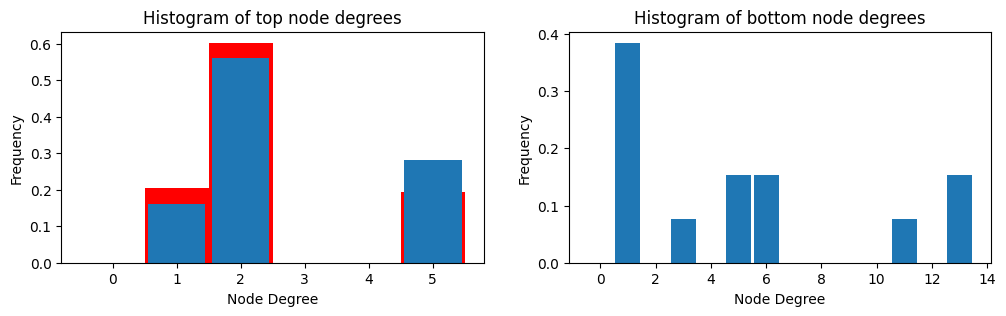

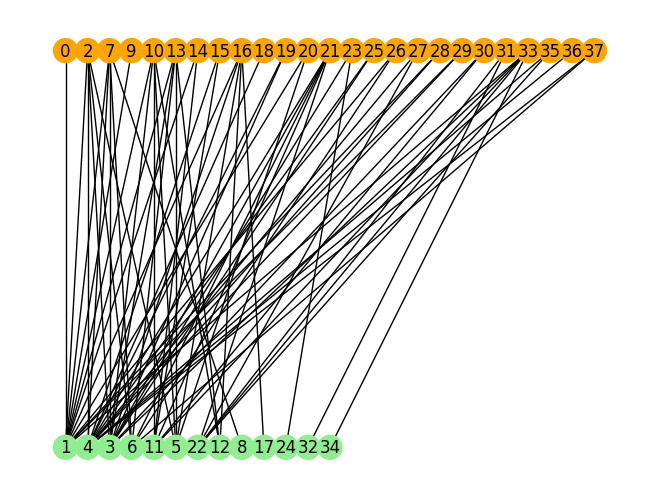

In [377]:
test_distr = stats.rv_discrete(name='custm', values=([1, 2, 2, 2, 5], [1/5 for i in range(5)])) # TODO: changed [1, 2, 2, 2, 5] to [1, 2, 3, 4, 5]
G = bipartite_graph_generator(test_distr,25,0.75)
analyize_distributions_bipartite_graph(G,distribution=test_distr)
draw_bipartite_graph(G,sort_top=False)

### Test 2

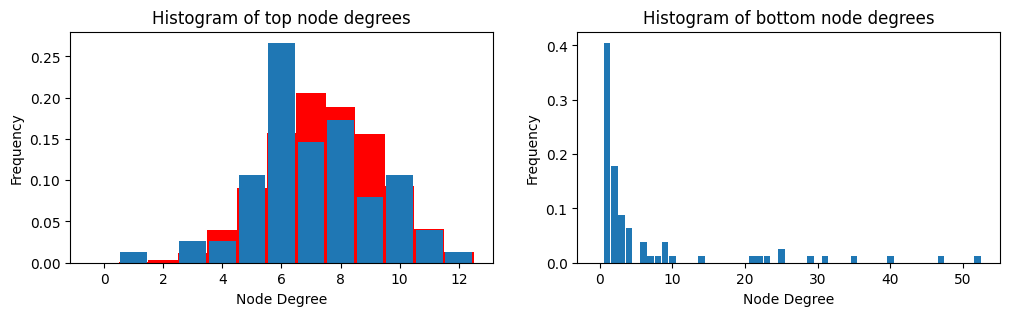

In [378]:
binomial = stats.binom(15, 0.5)
G = bipartite_graph_generator(binomial,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=binomial)

### Test 3

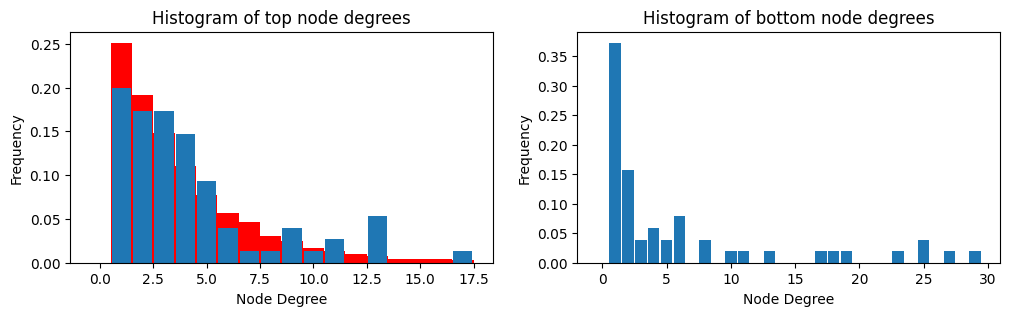

In [379]:
geometric = stats.geom(0.25)
G = bipartite_graph_generator(geometric,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=geometric)

### Test 4

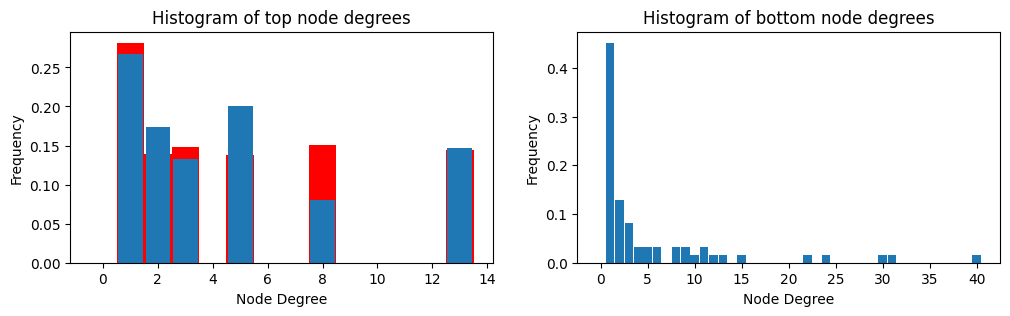

In [380]:
uniform_trunc_fibonacci = stats.rv_discrete(name='custm', values=([1, 1, 2, 3, 5, 8, 13], [1/7 for i in range(7)])) # changed [1, 1, 2, 3, 5, 8, 13]
G = bipartite_graph_generator(uniform_trunc_fibonacci,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=uniform_trunc_fibonacci)

## 2 Implementation of projection and analysis

**Implement** the functions for the analysis of graphs.
You can use your own implementation or the [networkx](https://networkx.github.io/documentation/stable/) implementations.
*Hint: When using networkx the functions can mostly be written as one-liners.*


**Implement** a projection of the graph onto both the top and bottom node sets. Use the [networkx implementation](https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.bipartite.html) to do this.
*Hint: You can use the [G.nodes(data=true)](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.nodes.html) flag to get the nodes with their corresponding attribute dictionary.*


In [381]:
'''own methods'''
def get_bipartition(G, attribute='bipartite'):
    '''
    G: networkx graph
    attribute: attribute name which stores bipartition info
    return: set of nodes for respectively top and bottom nodes
    '''
    top_nodes = set(n for n,d in G.nodes(data=True) if d[attribute]==0)
    bottom_nodes = set(n for n,d in G.nodes(data=True) if d[attribute]==1)
    return top_nodes, bottom_nodes

'''predefined methods'''
def Connected(G):
    # connectedness of G
    connected = nx.is_connected(G)    
    return connected

def ASP(G):
    # average shortest path in G
    if Connected(G):
        ASP = nx.average_shortest_path_length(G) 
        return ASP
    else:
        return float('inf')

def ALCC(G):
    # average clustering coefficient of G
    if Connected(G):
        ALCC = nx.average_clustering(G)
        return ALCC
    else:
        return -1
    
def NumNodes(G):
    # number of nodes of G
    return G.number_of_nodes()

def NumEdges(G):
    # number of edges of G
    return G.number_of_edges()

def Density(G):
    # density of G
  
    top_nodes, bottom_nodes = get_bipartition(G, attribute='bipartite')

    if (NumNodes(G) == len(top_nodes)) or (NumNodes(G) == len(bottom_nodes)):   # projected graph != bipartite graph
        Density = nx.density(G)
    else: # bipartite graph: density is E/(U*V) where E is the number of edges and U and V are the number of nodes in the two partions of the bipartite graph
        Density = NumEdges(G)/(len(top_nodes)*len(bottom_nodes)) # Def. 5.8 VL

    return Density 

def ADeg(G):
    # average degree of G
    ADeg = np.mean([G.degree(n) for n in G.nodes])
    return ADeg


def project_bipartite_graph(G, attribute='bipartite'):
    '''
    returns projected graphs.
    Two nodes in a projection have an edge if they share a neighbour.
    '''
    # computes the projections onto the top and bottom node sets of a bipartite graph
    top_nodes, bottom_nodes = get_bipartition(G, attribute='bipartite')
    top_graph = bipartite.projected_graph(G, top_nodes)
    bottom_graph = bipartite.projected_graph(G, bottom_nodes)
    
    return top_graph, bottom_graph

In [382]:
# compute all functions for a graph
functions = [Connected, NumNodes, NumEdges, ASP, ALCC, Density, ADeg]
def functions_on_graph(G,functions):
    return list(map(lambda f:(f.__name__,f(G)),functions))


## 3 Evaluation of generated and projected bipartite graphs

**Generate** bipartite graphs given the following parameters:

1. **Graph 1**
    * Distribution: Binomial(15, 0.5) -> stats.binom(15, 0.5)
    * Number of Top Nodes: 150
    * Overlap Ratio: 0.85
    
    
2. **Graph 2**
    * Distribution: Geometric(0.1) -> stats.geom(0.1)
    * Number of Top Nodes: 100
    * Overlap Ratio: 0.95
    
    
3. **Graph 3**
    * Distribution: Discrete Distribution with P(3)=0.1; P(6)=0.5; P(9)=0.3; P(15)=0.1 -> see Test 4 for an example of a custom discrete distribution
    * Number of Top Nodes: 150
    * Overlap Ratio: 0.5
    
---
    
**Analyze** the graphs with respect to:
* connectedness
* average shortest path
* density
* average degree

---

**Project** the graph onto both the top and bottom node sets and **analyze** the projected graphs with respect to:
* connectedness
* average shortest path
* average local clustering coefficient
* density
* average degree

---

**Try to generate connected graphs**. 
Notice that a correctly implemented generator does not guarantee connectedness.
Compare the results of the projections and the original graph.
Write a **short** summary of your observations, e.g., what is similar, what is not, what changes for the projections etc.

### Graph 1

In [383]:
binomial = stats.binom(15, 0.5)
G = bipartite_graph_generator(binomial,150,0.85)

In [384]:
#draw_bipartite_graph(G,sort_top=False)

In [385]:
def analyze_graph(graph, name:str):
    ## connected?
    print(f'{name} is connected: ', Connected(graph))

    ## average shortest path
    print(f'ASP of {name}: ', ASP(graph))

    ## average clustering coefficient
    print(f'ALCC of {name}: ', ALCC(graph))

    ## density
    print(f'density of {name}: ', Density(graph))

    ## average degree
    print(f'average degree of {name}: ', ADeg(graph))

In [386]:
# analyze original graph
analyze_graph(G, 'original graph')

original graph is connected:  True
ASP of original graph:  3.2134991964764
ALCC of original graph:  0.0
density of original graph:  0.04313492063492064
average degree of original graph:  6.836477987421383


In [387]:
top_graph, bottom_graph = project_bipartite_graph(G)

# analyze top graph
analyze_graph(top_graph, 'top graph')

print('\n')

# analyze bottom graph
analyze_graph(bottom_graph, 'bottom graph')

top graph is connected:  True
ASP of top graph:  1.1951677852348994
ALCC of top graph:  0.8641322233117638
density of top graph:  0.8048322147651007
average degree of top graph:  119.92


bottom graph is connected:  True
ASP of bottom graph:  1.9665668662674651
ALCC of bottom graph:  0.8031260274137754
density of bottom graph:  0.12147134302822926
average degree of bottom graph:  20.285714285714285


#### Observations:

- comparison of original graph and projections
    - ASP decreases when projected
    - ALCC defined only on projected graph
    - density increases when projected
    - average degree increases when projected
- comparison of projections
    - slightly lower ASP in top graph
    - slightly higher ALCC in top graph
    - higher density in top graph
    - enormously higher average degree in top graph

### Graph 2

In [388]:
geom = stats.geom(0.1)
G = bipartite_graph_generator(geom, 100, 0.95)
# TODO


In [389]:
# analyze original graph
analyze_graph(G, 'original graph')

original graph is connected:  True
ASP of original graph:  2.8407670530420384
ALCC of original graph:  0.0
density of original graph:  0.12308510638297872
average degree of original graph:  11.927835051546392


In [390]:
top_graph, bottom_graph = project_bipartite_graph(G)

# analyze top graph
analyze_graph(top_graph, 'top graph')

print('\n')

# analyze bottom graph
analyze_graph(bottom_graph, 'bottom graph')

top graph is connected:  True
ASP of top graph:  1.3153535353535353
ALCC of top graph:  0.8689263786478268
density of top graph:  0.6876767676767677
average degree of top graph:  68.08


bottom graph is connected:  True
ASP of bottom graph:  1.4813543811484786
ALCC of bottom graph:  0.8603324996348527
density of bottom graph:  0.5280256234271333
average degree of bottom graph:  49.1063829787234


In [391]:
#draw_bipartite_graph(G,sort_top=False)

#### Observations: 

- comparison of original graph and projections
    - ASP decreases when projected
    - ALCC defined only on projected graph
    - density increases when projected
    - average degree increases when projected
- comparison of projections
    - slightly lower ASP in top graph
    - slightly higher ALCC in top graph
    - higher density in top graph
    - higher average degree in top graph

-> similar results to test 1

### Graph 3

In [392]:
some_discrete_dist = stats.rv_discrete(name='custm', values=([3,6,9,15], [0.1, 0.5, 0.3, 0.1]))
G = bipartite_graph_generator(some_discrete_dist, 150, 0.5)
# TODO

In [393]:
# analyze original graph
analyze_graph(G, 'original graph')

original graph is connected:  False
ASP of original graph:  inf
ALCC of original graph:  -1
density of original graph:  0.012945205479452054
average degree of original graph:  3.0899182561307903


In [394]:
top_graph, bottom_graph = project_bipartite_graph(G)

# analyze top graph
analyze_graph(top_graph, 'top graph')

print('\n')

# analyze bottom graph
analyze_graph(bottom_graph, 'bottom graph')

top graph is connected:  False
ASP of top graph:  inf
ALCC of top graph:  -1
density of top graph:  0.17664429530201342
average degree of top graph:  26.32


bottom graph is connected:  False
ASP of bottom graph:  inf
ALCC of bottom graph:  -1
density of bottom graph:  0.024841984069174556
average degree of bottom graph:  14.482876712328768


In [395]:
#draw_bipartite_graph(G,sort_top=False)

#### Observations:

- comparison of original graph and projections
    - ASP decreases when projected
    - ALCC defined only on projected graph
    - density increases when projected
    - average degree increases when projected
- comparison of projections
    - slightly lower ASP in top graph
    - slightly higher ALCC in top graph
    - higher density in top graph
    - higher average degree in top graph

-> similar results to test 1 & 2